In [1]:
import sys
sys.path.append("..")
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense, normalize_spectra
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
def torchify(X, dtype=torch.float):
    return torch.from_numpy(X).type(dtype)

# Training data
from scipy.signal import savgol_filter, morlet, morlet2, cwt, gausspulse, ricker
dataset_dict = load_spectral_data([
    "../raw_data/DataDavid/UVVIS/*.asc",
    "../raw_data/DataHenry23/Perkin/New_*/*.asc",
    "../raw_data/DataJulie/07_09_spectro/**/*.asc",
    "../raw_data/DataJulie/14_09_2023/*.asc",
    "../raw_data/DataJulie/11_09_2023/*.asc",
    "../raw_data/DataJulie/14_09_2023_histo/*.asc",
    "../raw_data/DataJulie/historique/*.asc",
], verbose=True)
wavelength = np.flipud(np.linspace(250, 2500, 226))
wl_mask = wavelength <= 2300
wavelength = wavelength[wl_mask]


X, Y = dataset_dict_to_dense(dataset_dict)
#X = savgol_filter(X, 11, 3, axis=-1)
print(X.shape, wl_mask.shape)
Xtot = X[:, wl_mask].copy()
Ytot = Y.copy().astype(np.int32)

from scipy.signal import cwt, ricker
offset = 0
octaves = 32
cwttot = np.asarray([cwt(x, ricker, np.arange(1, 129)) for x in Xtot ])[:, ::1, ::1].real

cwtorig = cwttot.copy()
dsmean = cwttot.mean(axis=0)
dsstd = cwttot.std(axis=0) * 2
cwttot = (cwttot-dsmean) / dsstd

valid_mask = np.logical_or(Y[:, 0] == 13, Y[:, 0] == 12)
Xv = cwttot[valid_mask]
Yv = Y[valid_mask]
X = cwttot[~valid_mask]
Y = Y[~valid_mask]



X = X[Y[:,5]< 3,:]
Y = Y[Y[:,5]< 3,:].astype(np.int32)

print(np.count_nonzero(Y[:, 1] == 0))
print(np.count_nonzero(Y[:, 1] == 1))
print(np.count_nonzero(Y[:, 1] == 2))

Xv = Xv[Yv[:,5]< 2,:]
Yv = Yv[Yv[:,5]< 2,:].astype(np.int32)

labels = Y[:, 1]
labels_v = Yv[:, 1]

from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch
print(X.shape)
loader = DataLoader(TensorDataset(torchify(np.expand_dims(X, 1)), torchify(labels, torch.long)), batch_size=8, shuffle=True)
loader_v = DataLoader(TensorDataset(torchify(np.expand_dims(Xv, 1)), torchify(labels_v, torch.long)), batch_size=64, shuffle=False)

Loading 115 files from ../raw_data/DataDavid/UVVIS/*.asc
Loading 360 files from ../raw_data/DataHenry23/Perkin/New_*/*.asc
Loading 43 files from ../raw_data/DataJulie/07_09_spectro/**/*.asc
Loading 24 files from ../raw_data/DataJulie/14_09_2023/*.asc
Loading 16 files from ../raw_data/DataJulie/11_09_2023/*.asc
Loading 13 files from ../raw_data/DataJulie/14_09_2023_histo/*.asc
Loading 21 files from ../raw_data/DataJulie/historique/*.asc
(592, 226) (226,)
22
36
28
(86, 128, 206)


In [3]:
from scipy import signal
def reconstruct(C, widths):
    return np.sum([ signal.convolve(C[i], signal.ricker(len(C[0,:]), w)/w**2, mode="same") for i, w in enumerate(widths) ], axis=0)

def filtered(sig, offset, octaves):
    widths = np.arange(1, offset+octaves+1)
    C = cwt(sig, signal.ricker, widths)
    C[:offset] = 0
    C[offset+octaves:] = 0
    return reconstruct(C, widths)

['offsets', 'offset_32_raw', 'offset_32_fit', 'offset_64_raw', 'offset_64_fit']
float64


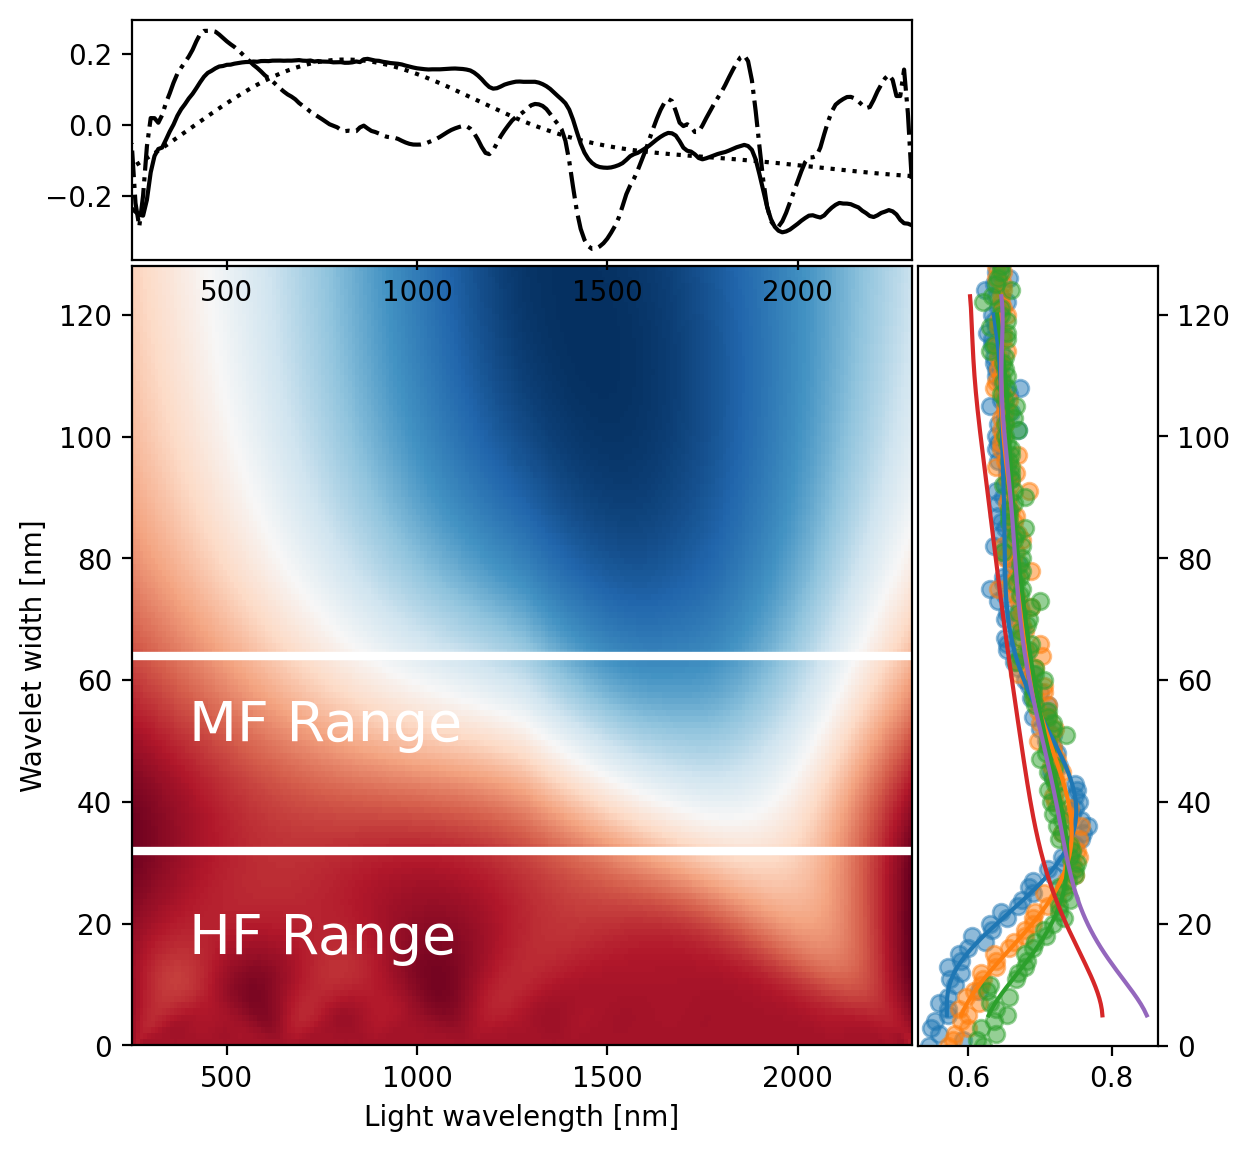

In [5]:
heat = np.load("../data/heat.npz")
heat2 = np.load("../data/heat2.npz")
print(list(heat2.keys()))
octaves=64
offset=0
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

xxmean = Xtot[0].mean()
print(X.dtype)
sample = cwtorig[0].copy() #, s = cwt(Xtot[0], wavelet='morlet', nv=20)
#Wx = np.flipud(Wx)
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(6, 6), dpi=200)

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
vmax = abs(sample).max()
ax.matshow(sample, cmap="RdBu", extent=[wavelength[-1], wavelength[0], 0, len(sample)] , origin="lower")#
ax.set_aspect(16)
ax_histy.scatter(heat["width32"], heat["offsets"], alpha=0.5)
ax_histy.scatter(heat["width48"], heat["offsets"], alpha=0.5)
ax_histy.scatter(heat["width64"], heat["offsets"], alpha=0.5)
ax_histy.plot(heat["width32_int"][1], heat["width32_int"][0])
ax_histy.plot(heat["width48_int"][1], heat["width48_int"][0])
ax_histy.plot(heat["width64_int"][1], heat["width64_int"][0])
ax_histy.plot(heat2["offset_32_fit"][1], heat2["offset_32_fit"][0])
ax_histy.plot(heat2["offset_64_fit"][1], heat2["offset_64_fit"][0])

#ax_histy.set_xlim(0.5,0.8)
ax_histy.xaxis.tick_bottom()
ax_histy.yaxis.tick_right()
ax_histx.plot(wavelength, (Xtot[0]-Xtot[0].mean())/100, color="k")
sig = filtered(Xtot[0]/100, 32, 32)
ax_histx.plot(wavelength, sig-sig.mean(), color="k", ls=":")
sig = filtered(Xtot[0]/100, 0, 32)
ax_histx.plot(wavelength, sig-sig.mean(), color="k", ls="dashdot")
# ax.axhline(0, c="w")
# ax.axhline(32, c="k", ls=":")
# ax.axhline(0, c="k", ls=":")
# ax.axhline(64, c="k", ls="dashdot")
# ax.axhline(33, c="k", ls="dashdot")
# ax.plot([wavelength[0]]*2, [32, 64], ls="dashdot", color="k")
# ax.plot([wavelength[-2]]*2, [32, 64], ls="dashdot", color="k")
ax.axhline(32, color="w", linewidth=3)
ax.axhline(64, color="w", linewidth=3)
ax.text(400, 15, "HF Range", fontdict={"fontsize":20}, color="w")
ax.text(400, 50, "MF Range", fontdict={"fontsize":20}, color="w")
ax.set_ylabel("Wavelet width [nm]")
ax.set_xlabel("Light wavelength [nm]")
ax.xaxis.tick_bottom()
plt.savefig("fig-wavelet-opt.pdf")


In [239]:
import torch.nn as nn
img_shape = (X.shape[1],X.shape[2])
class WaveletAutoEncoder(nn.Module):
    def __init__(self, complexity) -> None:
        super(WaveletAutoEncoder, self).__init__()
        c = complexity
        self.conv = nn.Sequential(
            nn.Conv2d(1    , 1 * c, 5, 2),
            #nn.BatchNorm2d(c),
            nn.LeakyReLU(0.0, True),
            nn.Dropout2d(0.4),
            nn.Conv2d(1 * c, 2 * c, 5, (1,2)),
            #nn.BatchNorm2d(2*c),
            nn.LeakyReLU(0.0, True),
            nn.Conv2d(2 * c, 4 * c, 5, (1,2)),
            #nn.BatchNorm2d(4*c),
            nn.Tanh(),
            nn.Conv2d(4 * c, 1 * c, 1, 1)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(c * 1, c * 4, 1, 1),
            #nn.BatchNorm2d(4*c),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(c * 4, c * 2, 5, (1,2)),
            #nn.BatchNorm2d(2*c),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(c * 2, c * 1, 5, (1,2)),
            #nn.BatchNorm2d(1*c),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(c * 1,  1, 5, 2),
            nn.Upsample(img_shape)
        )
        size = self.conv(torch.randn(1,1, img_shape[0], img_shape[1])).shape
        self.dense = nn.Sequential(
            nn.Linear(complexity*1*size[2]*size[3], 64),
            nn.LeakyReLU(0.2, True),
            nn.Linear(64, 3),
            nn.LogSoftmax(1)
        )
    
    def forward(self, X):
        bs = X.shape[0]
        X = self.conv(X)
        Y = self.deconv(X)
        X = self.dense(X.reshape(bs, -1))
        return X, Y



epoch 499 loss 1.1011 valid 1.05845 acc 0.636: 100%|██████████| 500/500 [00:38<00:00, 12.90it/s]


Text(0, 0.5, 'NLL Loss')

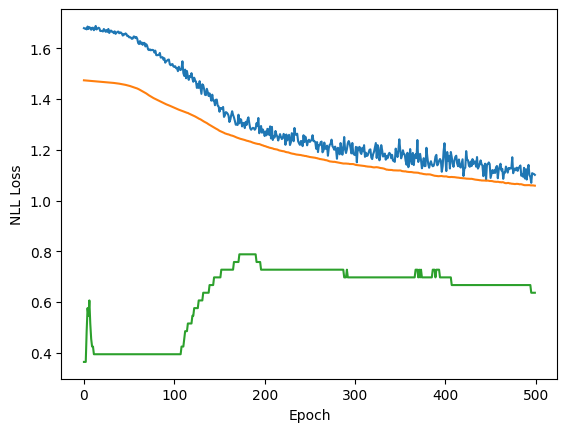

In [240]:
from torch.optim import Adam
from tqdm import trange
model = WaveletAutoEncoder(complexity=8)

optim = Adam(model.parameters(), lr=1e-5, weight_decay=5e-2)
classif_metric = nn.NLLLoss()
reconstruc_metric = nn.MSELoss()
losses = list()
losses_t = list()
accs = list()
progress = trange(500)
for e in progress:
    model.train()
    epoch_loss = 0.0
    for x, y in loader:
        optim.zero_grad()
        yp, xp = model(x)
        loss =  reconstruc_metric(xp, x) + classif_metric(yp, y)
        loss.backward()
        epoch_loss += loss.item()
        optim.step()
    epoch_loss /= len(loader)
    losses.append(epoch_loss)
    with torch.no_grad():
        model.eval()
        epoch_loss_t = 0.0
        for x, y in loader_v:
            yp, xp = model(x)
            loss = reconstruc_metric(x, xp) + classif_metric(yp, y)
            epoch_loss_t += loss.item()
            acc  = np.count_nonzero(np.argmax(yp, axis=-1)==y)/len(yp)
        epoch_loss_t /= len(loader_v)
        losses_t.append(epoch_loss_t)
        accs.append(acc)
    progress.set_description(f"epoch {e} loss {round(epoch_loss, 4)} valid {round(epoch_loss_t, 5)} acc {round(acc, 3)}")

fig, ax = plt.subplots()
ax.plot(losses)
ax.plot(losses_t)
ax.plot(accs)
ax.set_xlabel("Epoch")
ax.set_ylabel("NLL Loss")

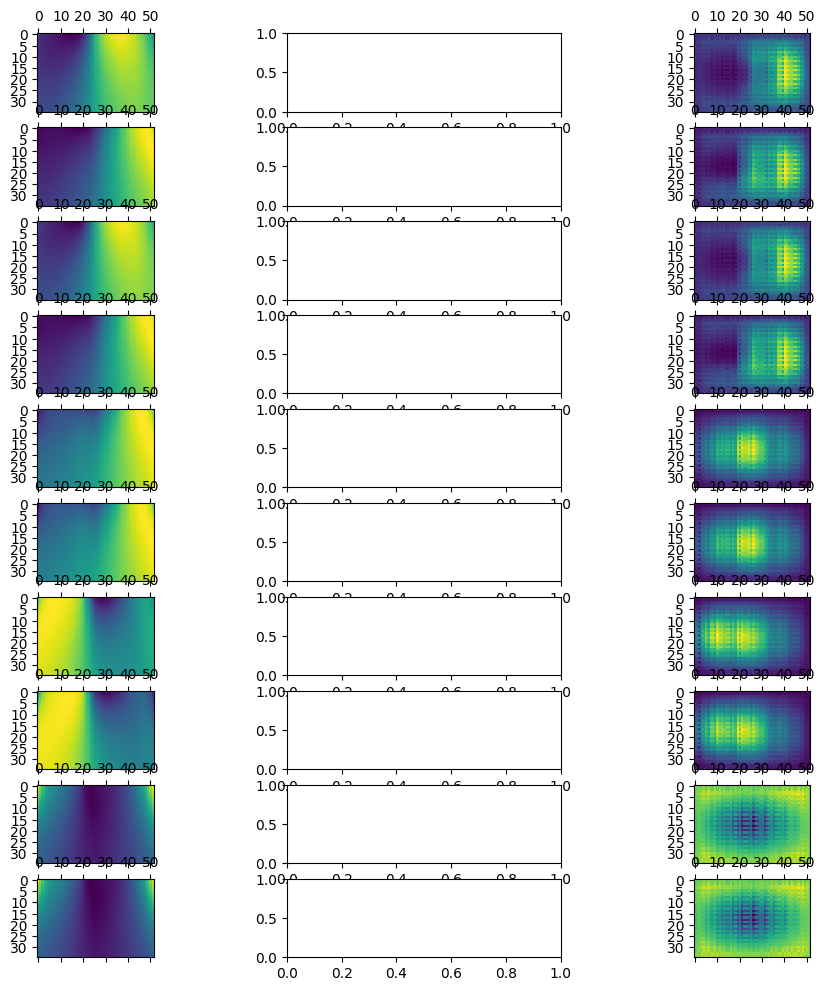

In [241]:
fig, axs = plt.subplots(10, 3, figsize=(12,12))
model.eval()
for i in range(10): 
    _, pred = model(torch.from_numpy(X[i][np.newaxis, np.newaxis]).type(torch.float))
    pred = pred.detach().numpy()[0,0]
    axs[i, 0].matshow(X[i])
    #axs[i, 1].plot(X[i])
    axs[i, 2].matshow(pred)

In [77]:
with torch.no_grad():
        model.eval()
        epoch_loss_t = 0.0
        for x, y in loader_t:
            yp, xp = model(x)
            print()

0.5581395348837209


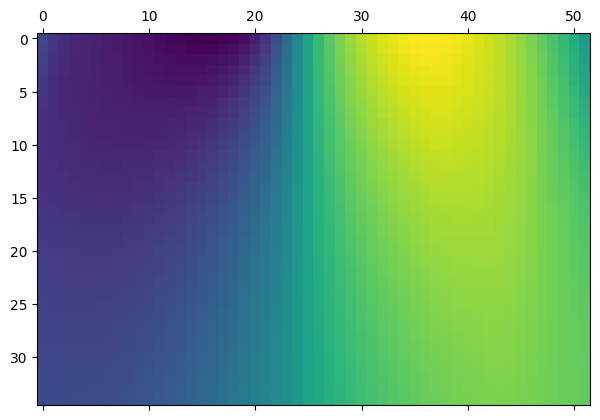

In [242]:
plt.matshow(X[0])

(127, 100)
(127,)


AttributeError: module 'pywt' has no attribute 'icwt'

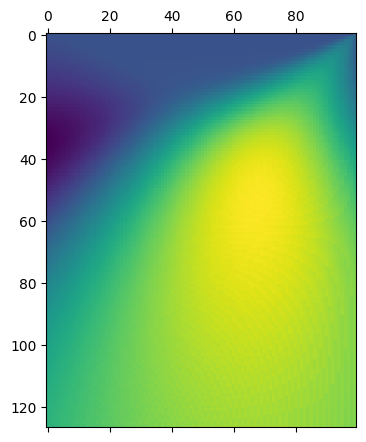

In [29]:
import torch
import pywt

wavelet = pywt.ContinuousWavelet('mexh')
t = pywt.cwt(torch.sin(torch.linspace(0,1,100)).numpy(), scales=np.arange(1,128), wavelet=wavelet)
print(t[0].shape)
plt.matshow(t[0])
print(t[1].shape)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


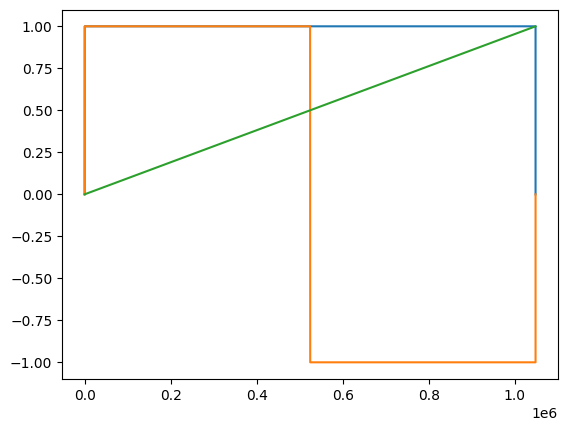

In [18]:
print(wavelet)
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.asarray(wavelet.wavefun(20)).T)